# Intro to LLM
## Petr Sokerin, SMILES 2025

**Plan of the seminar:**


*   Recap of LLM theory
*   Inferring LLM
* LangChain framework and RAG
* Fine-tune LLM



  

### **LLM Theory**  
Large Language Models (LLMs) like GPT use the **Transformer architecture**, where **self-attention** computes contextual relationships between words.  

##### **Self-Attention Formula**  
For input embeddings $X$, the attention weights $A$ are calculated as:  

$$
A = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

where:  
- $Q$ (Query), $K$ (Key), $V$ (Value) are linear projections of $X$.  
- $d_k$ = dimension of keys (scaling factor for stability).  

##### **Intuition**  
- **$QK^T$**: Measures similarity between words.  
- **Softmax**: Normalizes weights to focus on relevant words.  
- **Output**: Weighted sum of values $V$.  

##### **Code Snippet (PyTorch)**  
```python
import torch
import torch.nn.functional as F

def self_attention(Q, K, V, d_k):
    scores = torch.matmul(Q, K.transpose(-2, -1)) / (d_k ** 0.5)
    weights = F.softmax(scores, dim=-1)
    return torch.matmul(weights, V)
```

## Language modelling

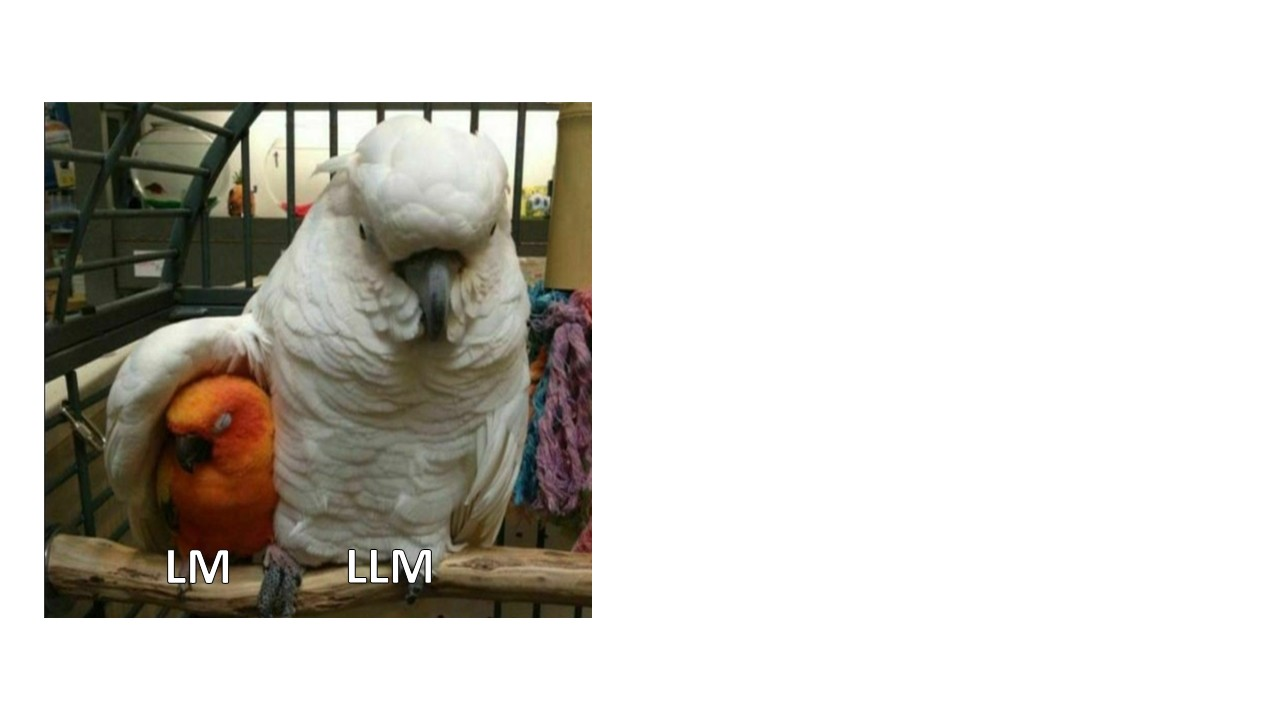

#### **Conditional Probability in LLM Text Generation**  

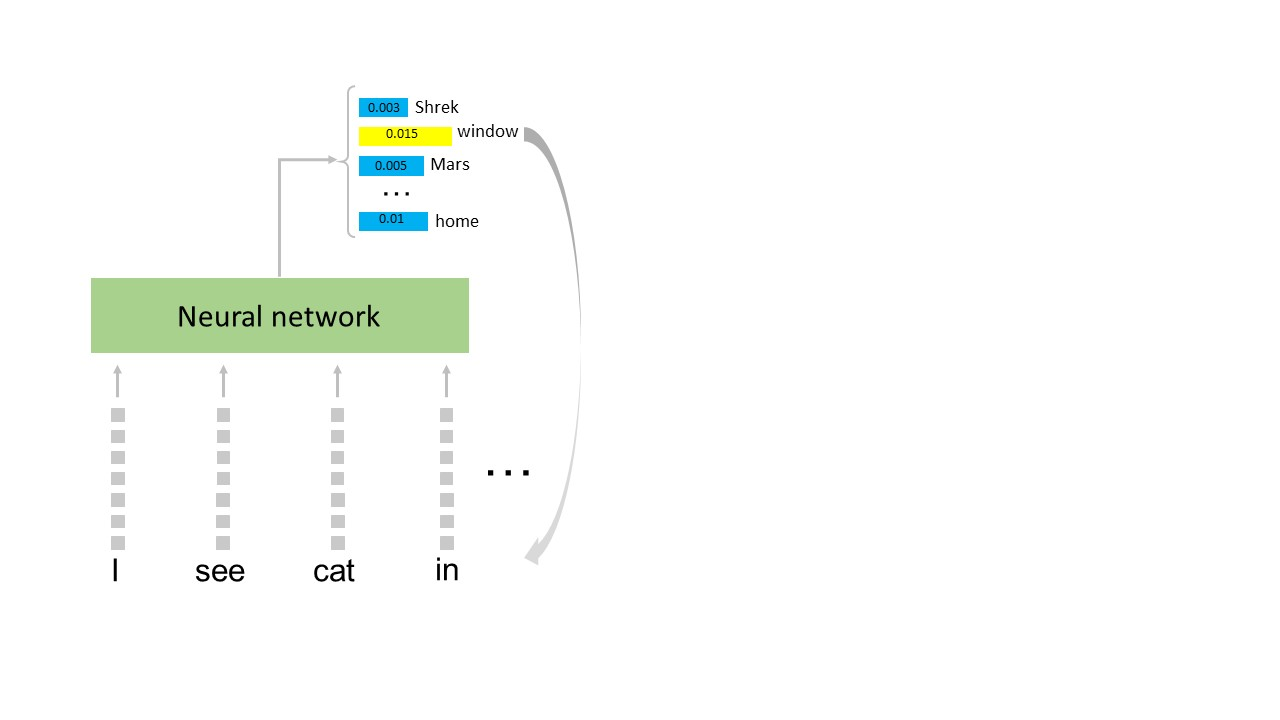

LLMs predict the next word by computing the **conditional probability distribution** over the vocabulary given previous tokens.  

##### **Formula**  
For a sequence of tokens $(w_1, w_2, \dots, w_{t-1})$, the probability of the next token $w_t$ is:  

$$
P(w_t | w_{<t}) = P(w_t | w_1, w_2, \dots, w_{t-1})
$$




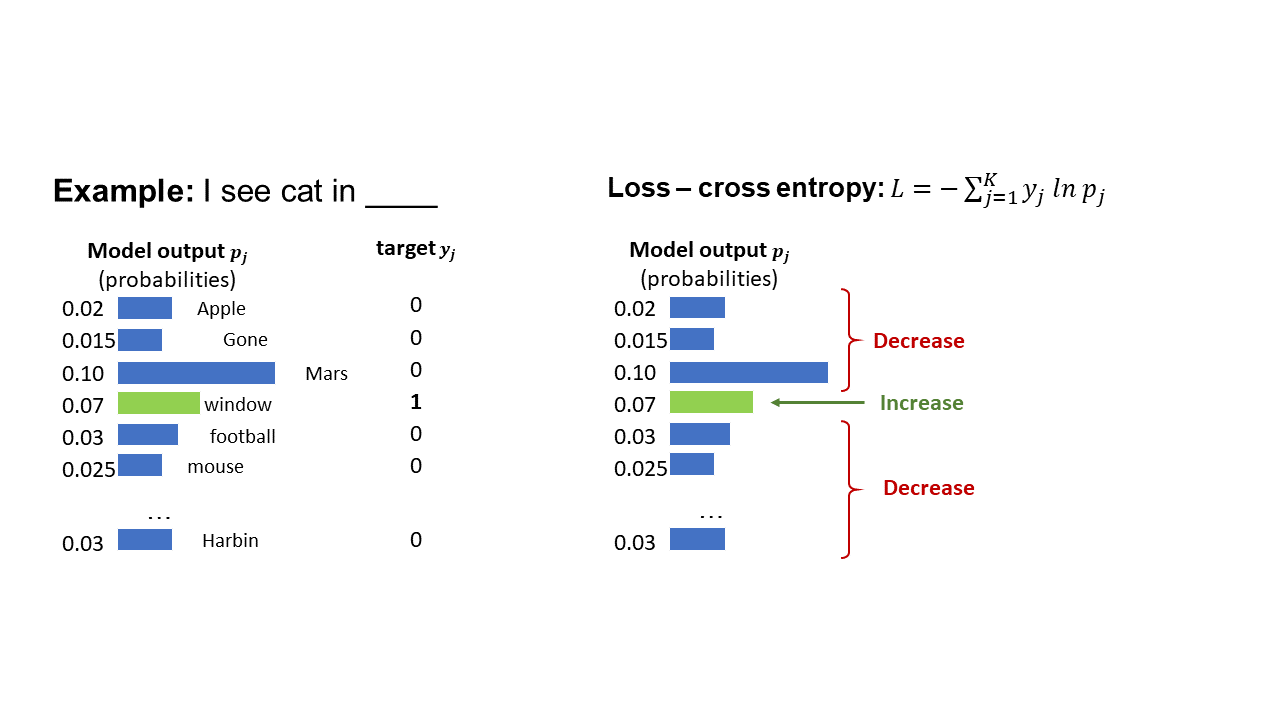

where:  
- $w_{<t}$ denotes all tokens before position $t$.  
- The distribution is generated by the **softmax** over the model’s logits:  

$$
P(w_t | w_{<t}) = \frac{\exp(z_{w_t})}{\sum_{j=1}^V \exp(z_j)}  
$$

- $z_j$ = logit for the $j$-th vocabulary word.  
- $V$ = vocabulary size.  

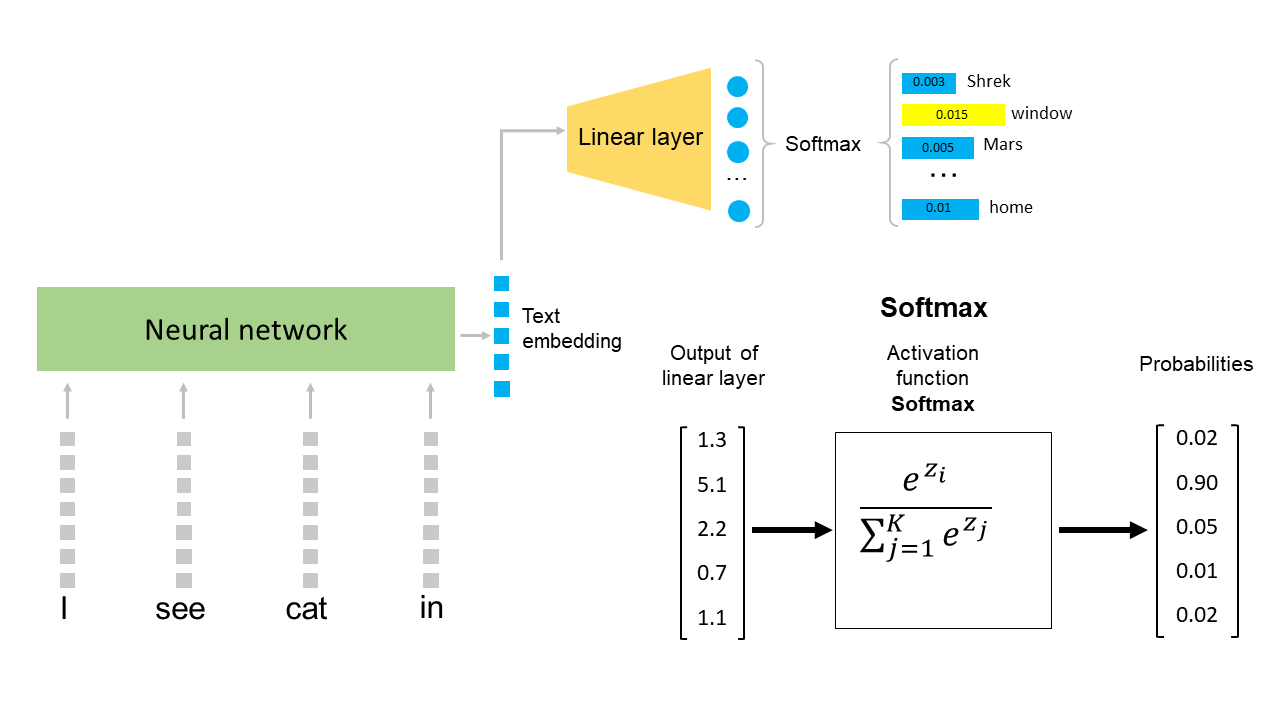

#### **Intuition**  
- The model assigns **scores (logits)** to every possible next word.  
- Softmax converts scores to probabilities, favoring high-scoring words.  

Let's install packages

In [2]:
!nvidia-smi

Thu Jul 17 01:16:33 2025       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A40          Off  | 00000000:CA:00.0 Off |                    0 |
|  0%   43C    P0    87W / 300W |  13508MiB / 46068MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# !pip install -U  \
# accelerate \
# transformers \
# einops \
# transformers_stream_generator \
# pyarrow \
# datasets \
# scikit-learn \
# tiktoken\
# langchain_community \
# faiss-cpu\
# sentence_transformers\
# torch

In [4]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

import numpy as np
import matplotlib.pyplot as plt

In [5]:
import os
os.environ["TRANSFORMERS_VERBOSITY"] = "error"

import warnings
warnings.filterwarnings("ignore")

## Decoder transformer

### Architecrute of **encoder-decoder transformer**

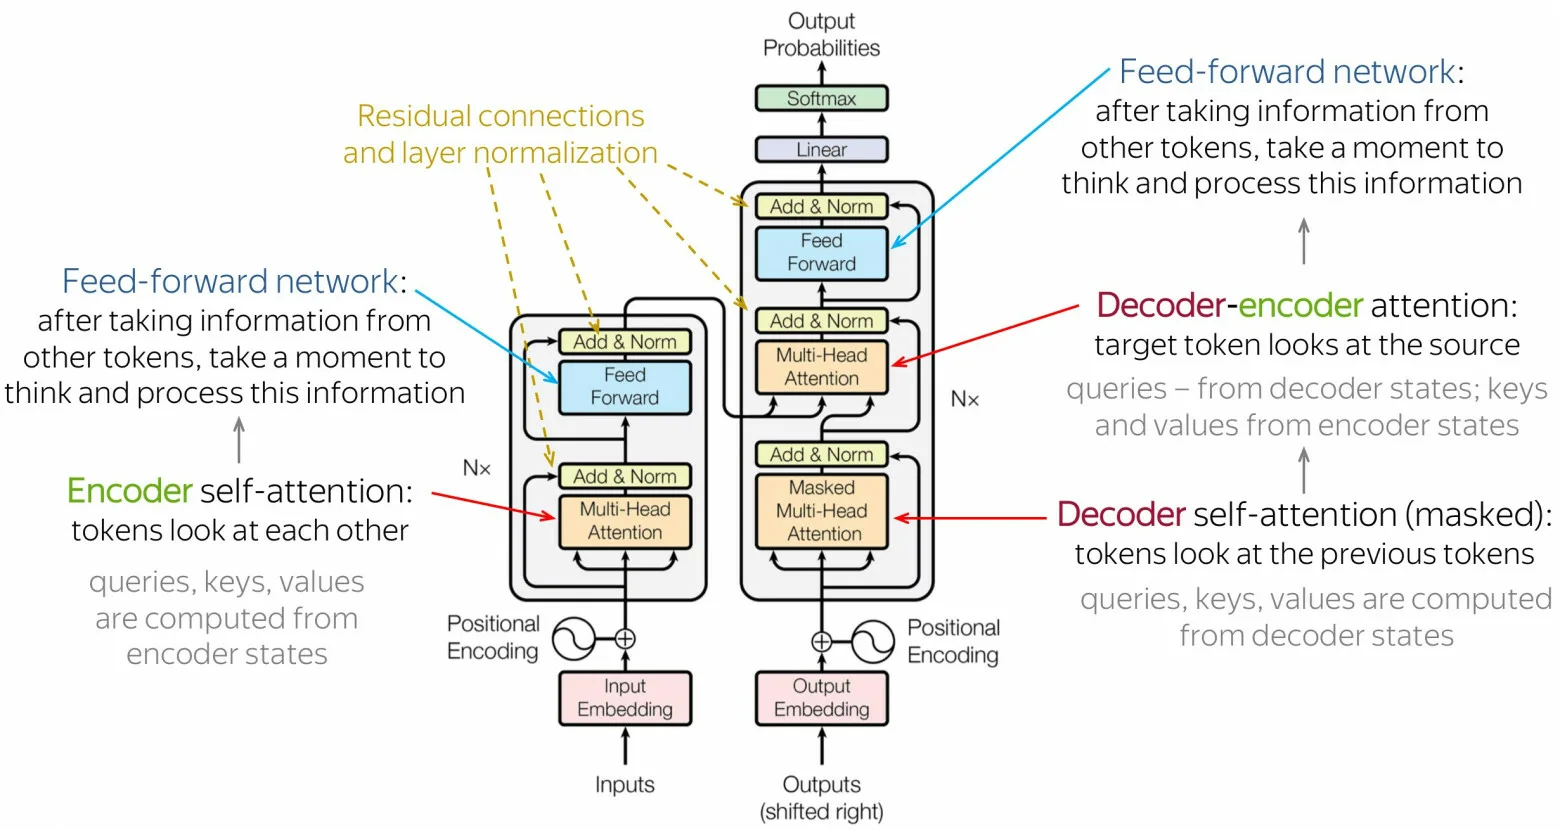

### Architecrute of **only-decoder transformer**

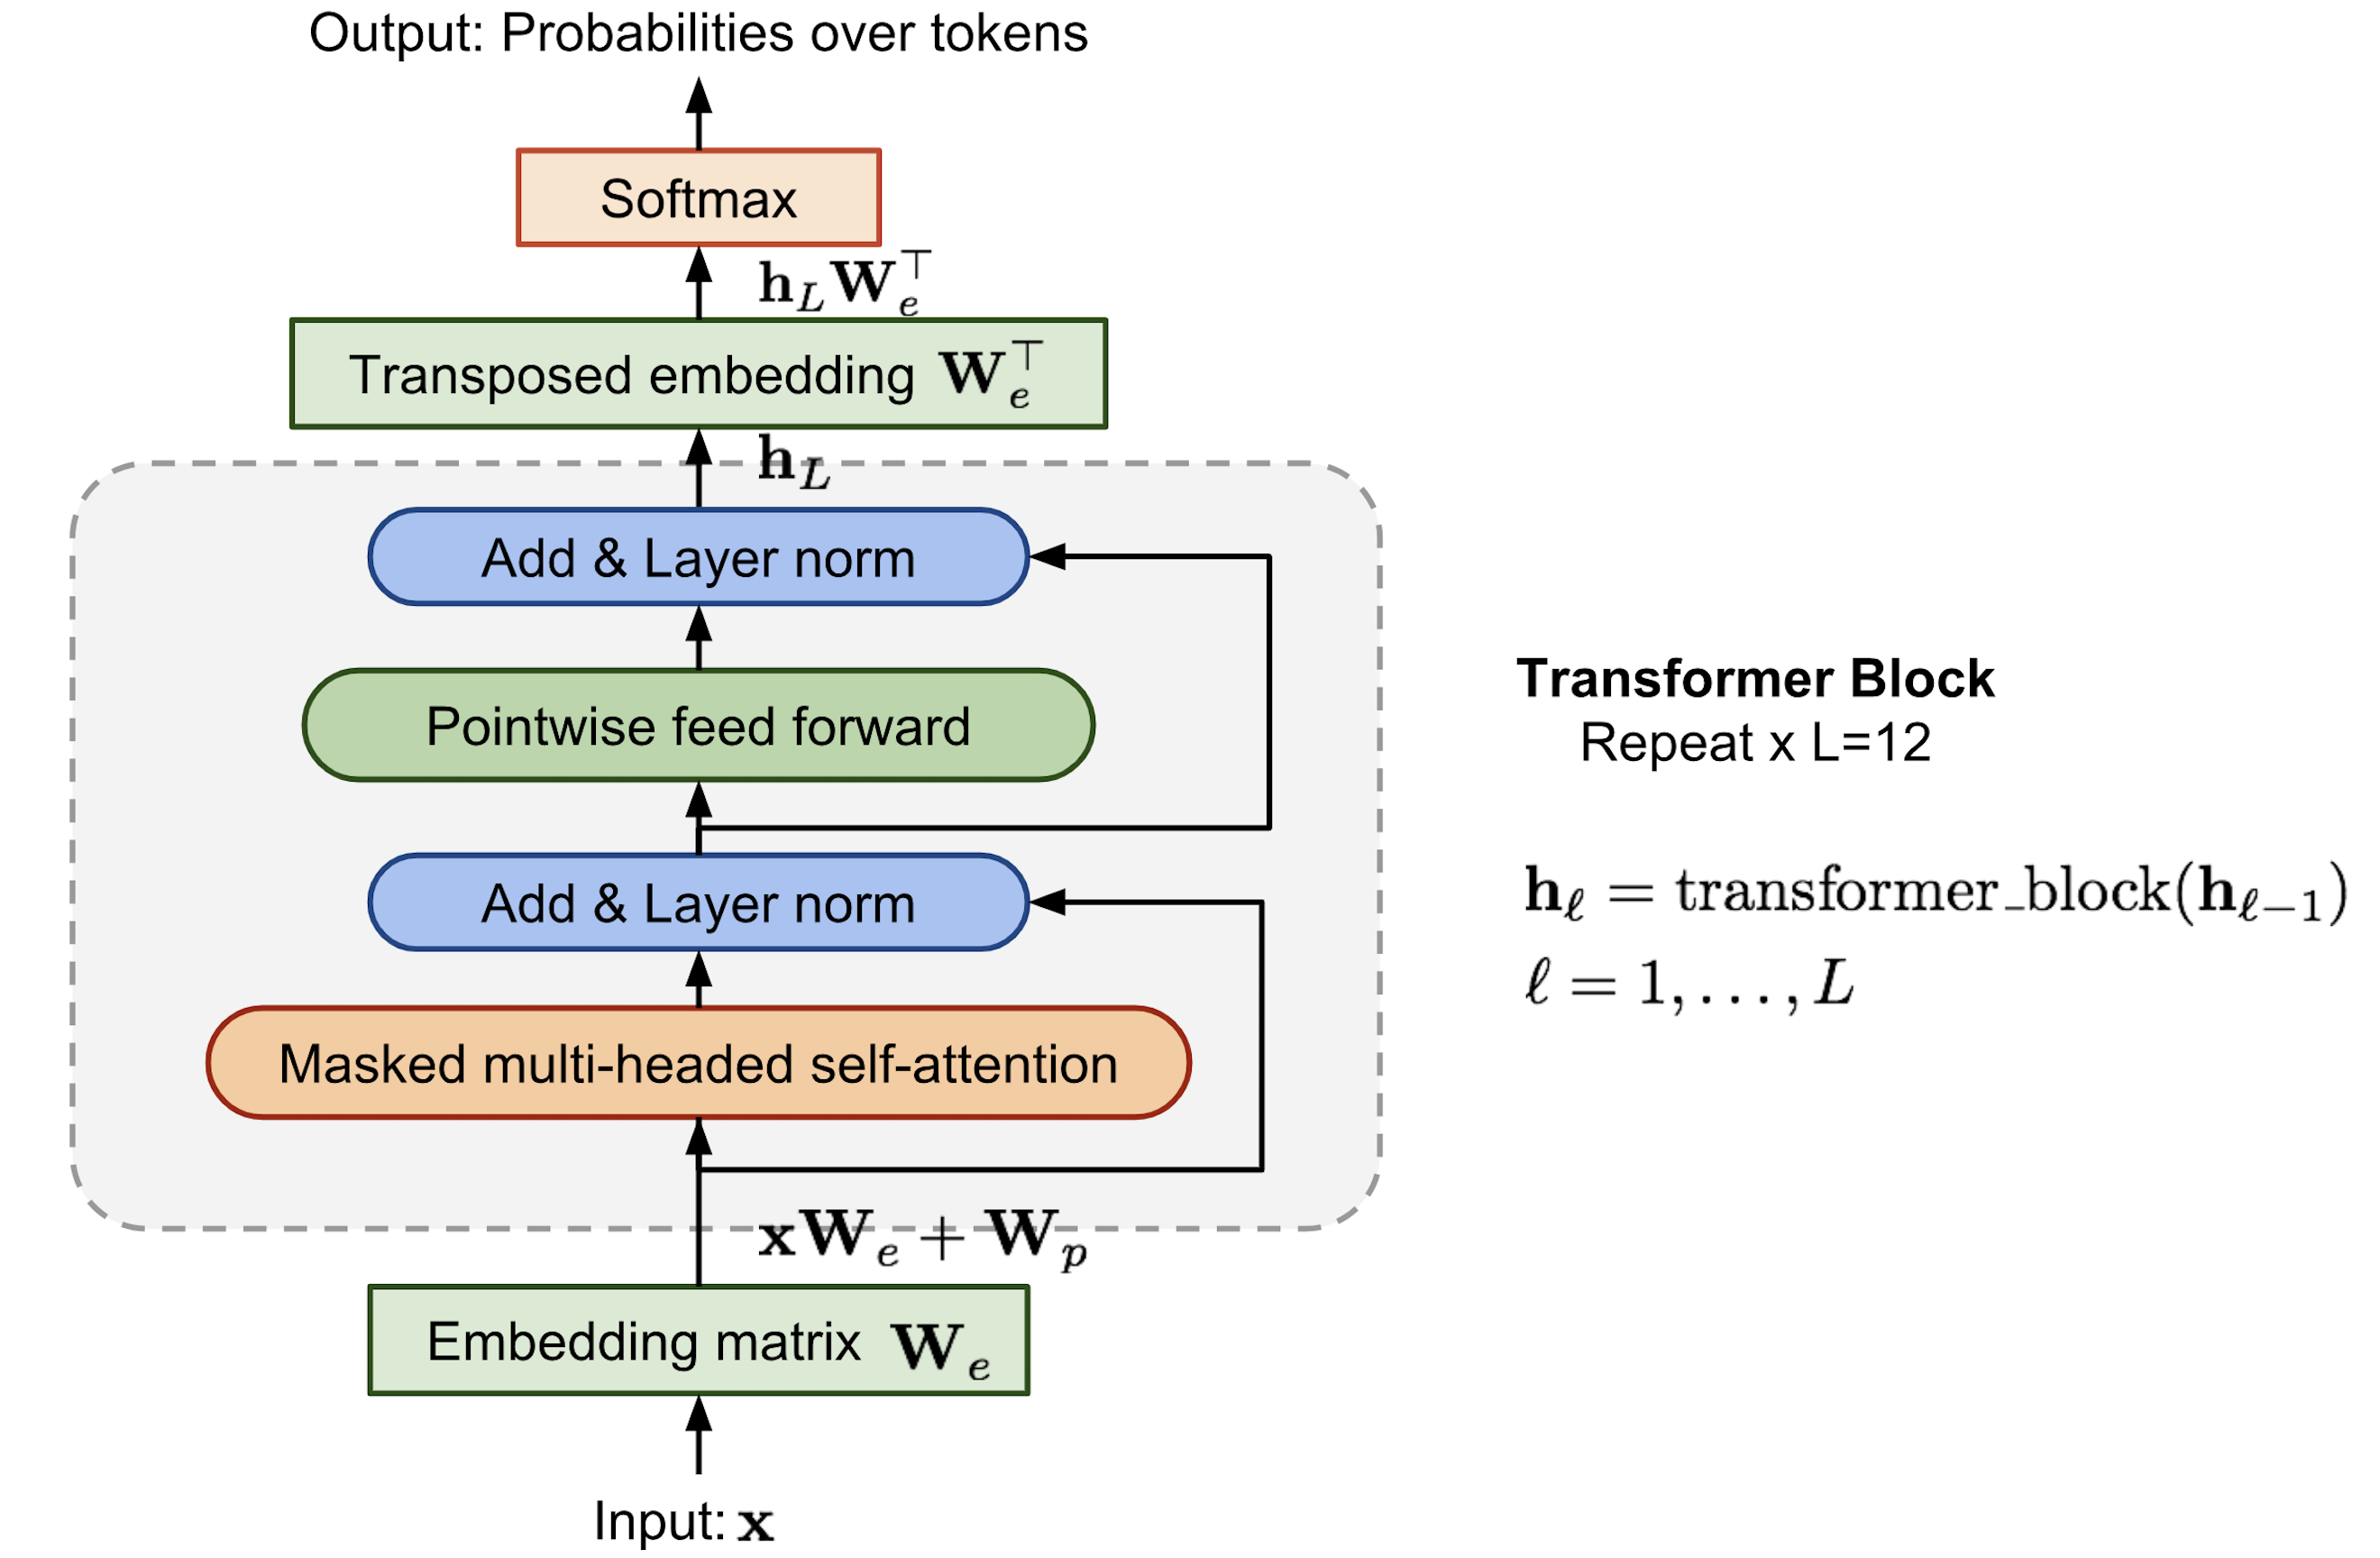

#### **Qwen Model**  

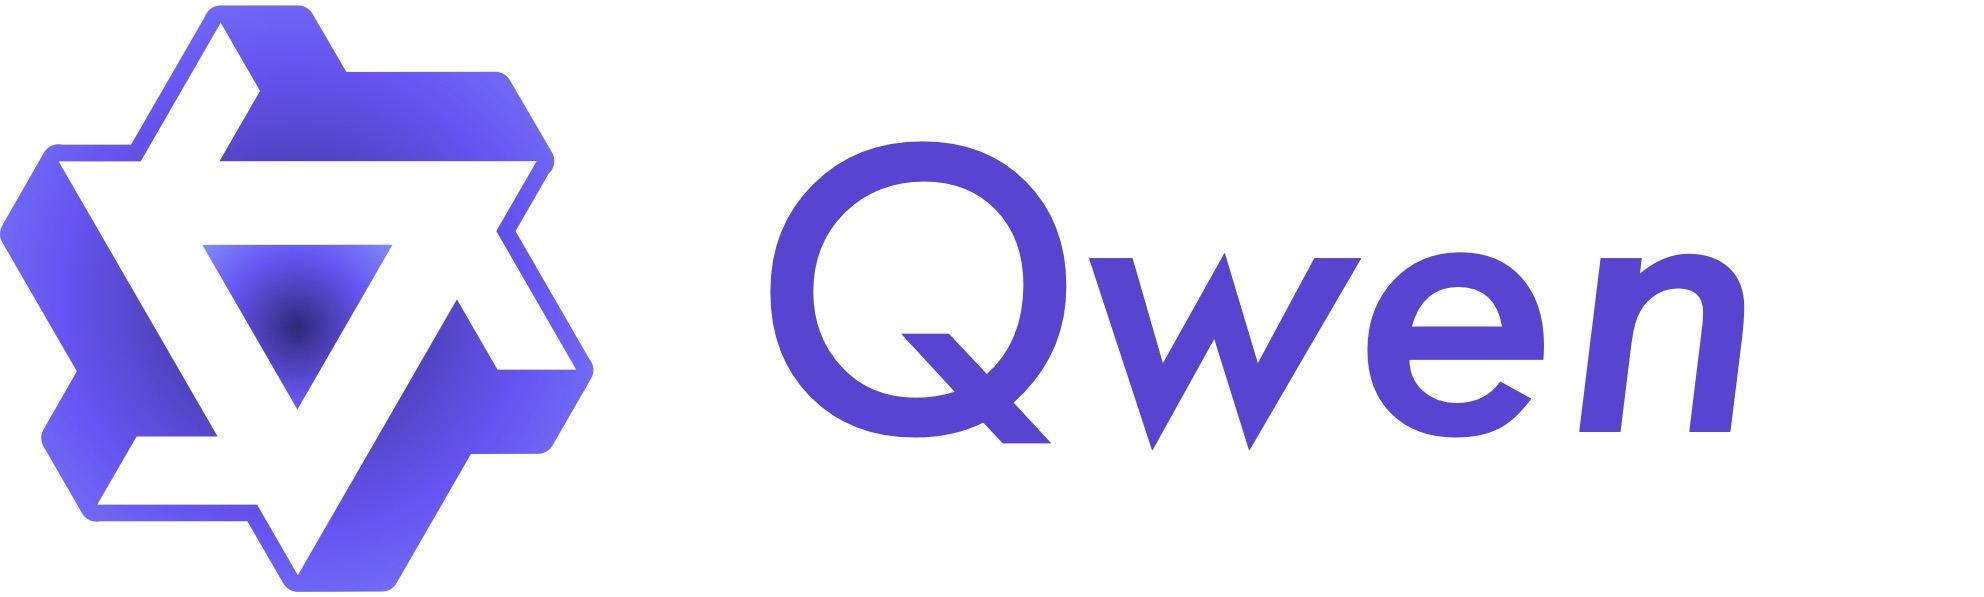



**Qwen** (通义千问) is a series of large language models developed by **Alibaba Cloud**, including:  
- **Qwen**: Base and chat-optimized versions.  
- **Qwen-Chat**: Fine-tuned for conversational tasks.  
- **Qwen-Code**: Specialized for code generation.  

##### **Key Features**  
✅ **Strong Performance**: Competes with Llama 2 and GPT-3.5 in Chinese/English benchmarks.  
✅ **Long Context Support**: Up to **32K tokens** in some variants.  
✅ **Open Weights**: Commercially usable (Apache 2.0 license).  

##### **Architecture**  
- **Decoder-only Transformer** (similar to GPT).  
- **Tokenizer**: Custom 150K+ vocabulary (supports Chinese/English/code).  
- **Training**: Pretrained on 3T+ tokens (web text, books, code).  


🔗 **Hugging Face Hub**: [https://huggingface.co/Qwen](https://huggingface.co/Qwen)

In [6]:
model_name = "Qwen/Qwen3-0.6B"

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, device_map="auto")

2025-07-17 01:16:40.982362: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-17 01:16:41.040921: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-17 01:16:41.040994: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-17 01:16:41.042644: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-17 01:16:41.051168: I tensorflow/core/platform/cpu_feature_guar

### **Tokenization**  

1. **Dividing Text into Tokens**  
   - Splits raw text into meaningful units (subwords/words) using a predefined vocabulary  
   - Example: `"Chatbots are helpful!"` → `["Chat", "bots", "are", "helpful", "!"]`  

2. **Mapping Tokens to IDs**  
   - Converts each token to a unique integer using the model's vocabulary  
   - Example: `{"Chat": 100, "bots": 101, ...}` → `[100, 101, 102, 103, 104]`  
   
example: https://tiktokenizer.vercel.app/

In [7]:
input_text = "How are you?"
tokens = tokenizer.tokenize(input_text, return_tensors="pt")
tokens

['How', 'Ġare', 'Ġyou', '?']

Get token ids as input to LLM

In [8]:
input_ids = tokenizer(input_text, return_tensors="pt")
input_ids

{'input_ids': tensor([[4340,  525,  498,   30]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

Generate output as token ids

In [9]:
input_ids = input_ids.to("cuda")
output = model.generate(**input_ids, max_new_tokens=50)
output

tensor([[ 4340,   525,   498,    30,   358,  2776,   264,  1602,  1661,   518,
           419,    11,   714,   358,  2776,   537,  2704,   421,   358,   646,
          2506,  2087,    13,   358,  2776,   264,   501, 19023,   448,   264,
          8381,   304, 17407,  9965,    13,   358,  2776,   264,  2699,   315,
           264, 31528,   380,   448,   264,  2696,   315, 10822,   323,   264,
         11677,   369,  6832,    13]], device='cuda:0')

Convert token ids back to the text

In [10]:
print(tokenizer.decode(output[0], skip_special_tokens=True))

How are you? I'm a very good at this, but I'm not sure if I can keep going. I'm a new graduate with a degree in Computer Science. I'm a bit of a hobbyist with a lot of coding and a passion for learning.


## Infering pre-trained model

Pre-trained decoder models (like GPT, Qwen, or LLaMA) are powerful for **text generation** and **autoregressive tasks**. They predict the next token based on previous context, making them ideal for:  

- **Chatbots** (Qwen-Chat, GPT-4)  
- **Code generation** (CodeLlama, StarCoder)  
- **Creative writing & summarization**  


These models require careful **prompt engineering** and **sampling strategies** (e.g., temperature, top-k) for optimal results.

Lets's take an example

In [11]:
example = "I'm glad to participate in machine leaning summer school SMILES"

input_ids = tokenizer(example, return_tensors="pt").to("cuda")
output = model.generate(**input_ids, max_new_tokens=50)
print(tokenizer.decode(output[0], skip_special_tokens=True))

I'm glad to participate in machine leaning summer school SMILES. I have a problem in the problem set that requires me to find the maximum value of the function $ f(x, y, z) = \frac{1}{x^2 + y^2 + z^2} + \frac{


### Generation Theory

#### **Greedy decoding**

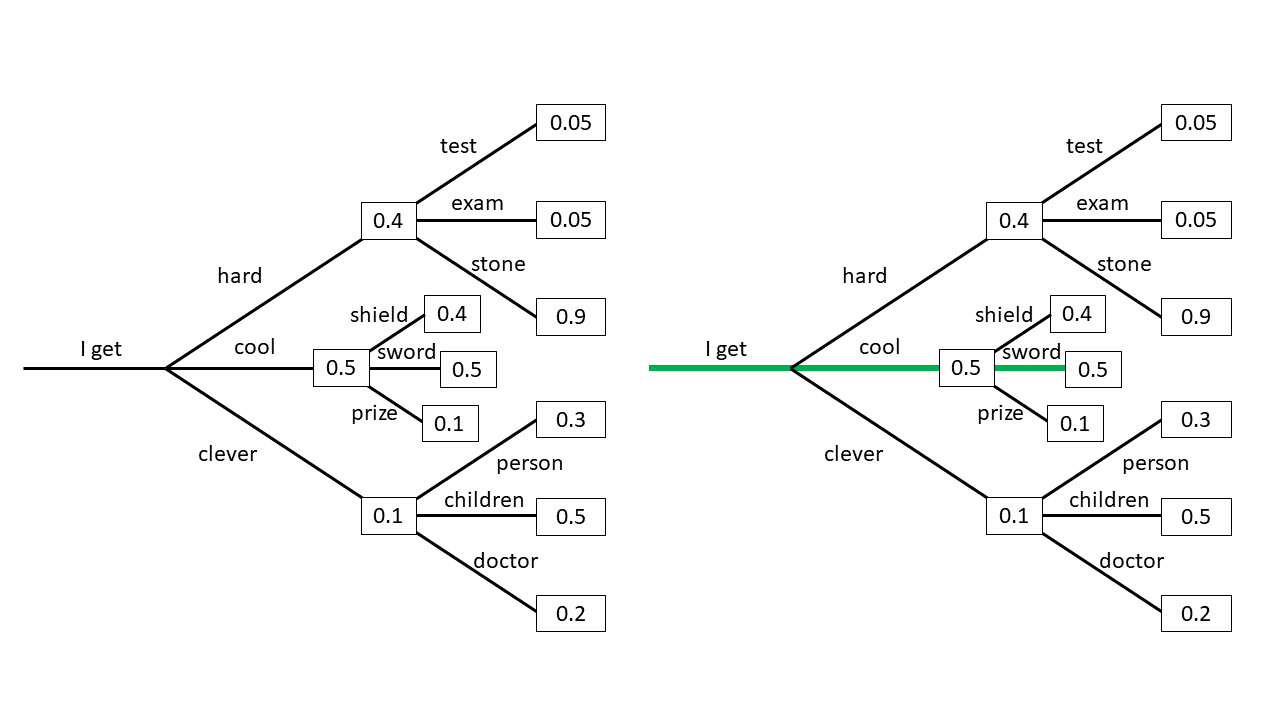




Greedy decoding is the **simplest** text generation strategy where the model always selects the **most probable next token** at each step.  

###### **How It Works:**  
1. At each timestep, the model:  
   - Computes probability distribution over vocabulary  
   - Selects the token with **highest probability**  
   - Feeds it back as input for the next step  

2. Process repeats until:  
   - An **end-of-sequence (EOS)** token is generated  
   - Maximum length is reached  

###### **Example:**  
Input prompt: *"The weather is"*  
Generation steps:  
1. `"The weather is"` → `"nice"` (P=0.6)  
2. `"The weather is nice"` → `"today"` (P=0.9)  
3. `"The weather is nice today"` → `"!"` (P=0.8)  
4. `"The weather is nice today!"` → `[EOS]`  

Final output: *"The weather is nice today!"*  

###### **Pros & Cons:**  
| **Advantages** | **Drawbacks** |  
|----------------|---------------|  
| ⚡ **Fast and simple** | 🔄 **Repetitive outputs** (no randomness) |  
| ✔ **Deterministic** (same prompt → same output) | 🌐 **Can miss better alternatives** (no exploration) |  

**When to Use:**  
- When you need **fast, deterministic** results  
- For tasks where **accuracy > diversity** (e.g., factual QA)  

In [12]:
output = model.generate(
    **input_ids,
    do_sample=False,
    max_new_tokens=50,
)

decode_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"generation: {decode_text}\n")

The following generation flags are not valid and may be ignored: ['temperature', 'top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


generation: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference between machine learning and computer vision. I need to know more



#### **Beam search**

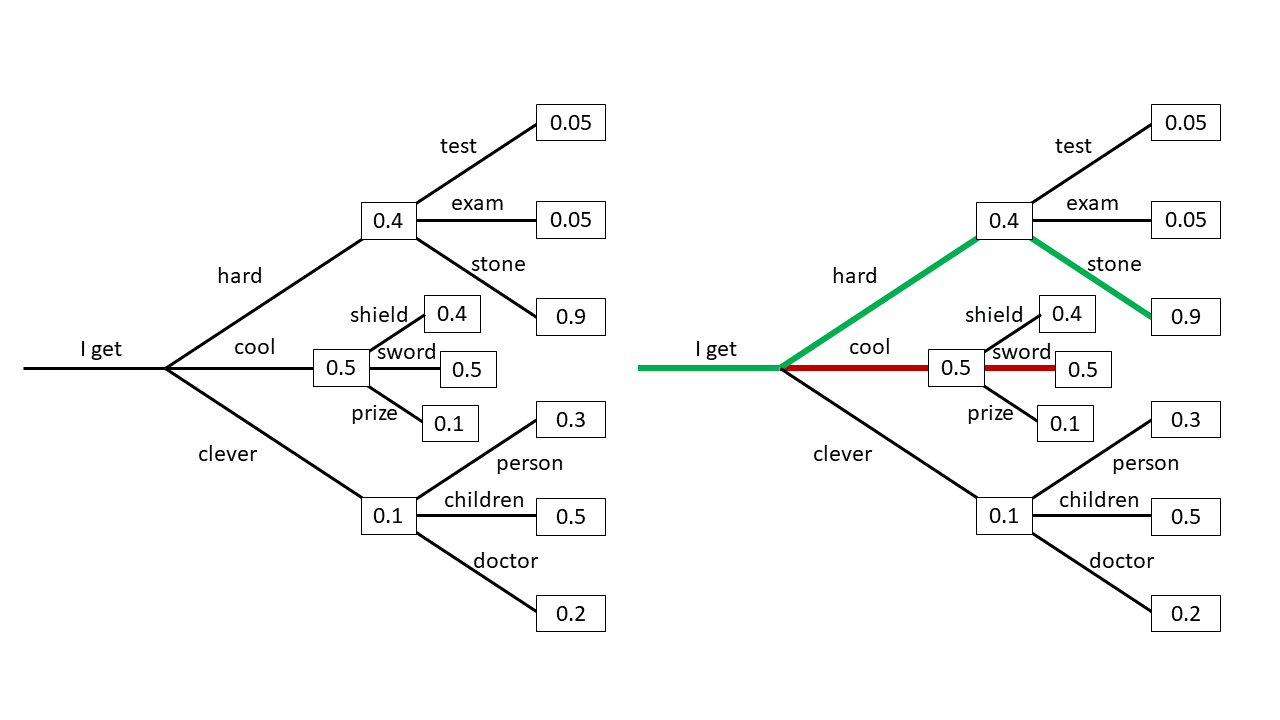



Beam search is an **advanced** text generation strategy that maintains multiple potential sequences (beams) to find higher-quality outputs.

###### **How It Works:**
1. At each timestep:
   - Keeps top *B* (beam width) most probable sequences
   - Expands each beam by considering top *k* next tokens
   - Prunes back to *B* highest-scoring complete sequences

2. Process terminates when:
   - All beams reach EOS tokens
   - Maximum length is reached

###### **Example:**
Beam width=2, prompt: *"The weather is"*
1. Keeps: `"nice"` (P=0.6) and `"sunny"` (P=0.4)
2. Expands to: `"nice today"` (P=0.54), `"sunny today"` (P=0.36), etc.
3. Selects highest final probability sequence

###### **Pros & Cons:**
| **Advantages** | **Drawbacks** |
|----------------|---------------|
| 🌟 **Better quality** than greedy | 🐢 **Slower** than greedy |
| 🔍 **Explores alternatives** | ⚖ **Tends to be generic** |

**When to Use:**
- When quality matters more than speed
- For formal text generation (summaries, translations)

In [13]:
output = model.generate(
    **input_ids,
    do_sample=True,
    max_new_tokens=50,
    num_beams=5,
    top_k=1, # fix randomness
)

decode_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"generation: {decode_text}\n")

generation: I'm glad to participate in machine leaning summer school SMILES 2023, and I'm very excited about the opportunity to learn from the experts in the field. I'm also very excited about the opportunity to learn from the experts in the field. I'm very excited about the opportunity to learn from



We also can make generation more diverse by adding `no_repeat_ngram_size`. Adding this parameter prevent generating the same phrases in one sample.

In [14]:
output = model.generate(
    **input_ids,
    do_sample=True,
    max_new_tokens=50,
    num_beams=5,
    top_k=1, # fix randomness
    no_repeat_ngram_size=2,
)

decode_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"generation: {decode_text}\n")

generation: I'm glad to participate in machine leaning summer school SMILES 2023, and I'm very excited about the opportunity to learn from the experts in the field. I hope to contribute to the development of the machine learning community and to make a meaningful impact on the future of AI. Please let me




#### **Sampling methods**

Sampling introduces **randomness** to generate diverse outputs by probabilistically selecting tokens.

###### **Common Variants:**
1. **Basic sampling**: Random selection weighted by probability
2. **Top-k**: Samples from *k* most likely tokens
3. **Top-p (nucleus)**: Samples from smallest set covering probability *p*

###### **How It Works:**
1. At each timestep:
   - Computes probability distribution
   - Applies selected sampling constraint
   - Randomly selects token from filtered distribution

###### **Example (Top-p=0.9):**
Prompt: *"The weather is"*
1. Filters to tokens covering 90% probability mass
2. Randomly selects from: `"nice"` (0.6), `"sunny"` (0.3), etc.

###### **Pros & Cons:**
| **Advantages** | **Drawbacks** |
|----------------|---------------|
| 🎨 **Creative, diverse outputs** | 🎲 **Less controllable** |
| 🌐 **Avoids repetition** | ⚠ **Can produce nonsense** |

**When to Use:**
- Creative writing/storytelling
- When variety is desired
- For more human-like responses

In [15]:
# set seed to reproduce results. Feel free to change the seed though to get different results
torch.random.manual_seed(0)

output = model.generate(
    **input_ids,
    do_sample=True,
    max_length=50,
    top_k=0 # deactivate top_k by setting top_k sampling to 0
)

decode_text = tokenizer.decode(output[0], skip_special_tokens=True)
print(f"generation: {decode_text}\n")

generation: I'm glad to participate in machine leaning summer school SMILES. But I'm not sure about the exact training data used for the model. Could you help me understand how to get the training data for this model? Also, I'm not sure about



In [16]:
torch.random.manual_seed(0)
n_samples=3

output = model.generate(
    **input_ids,
    do_sample=True,
    max_length=50,
    top_k=0,
    num_return_sequences=n_samples,
)

for i in range(n_samples):
    decode_text = tokenizer.decode(output[i], skip_special_tokens=True)
    print(f"generation {i}: {decode_text}\n")

generation 0: I'm glad to participate in machine leaning summer school SMILES. But I'm not sure about the exact training data used for the model. Could you help me understand how to get the training data for this model? Also, I'm not sure about

generation 1: I'm glad to participate in machine leaning summer school SMILES 2024. I think this is a good opportunity to learn and exchange experiences with other students. I have the opportunity to learn from the experts in the field and gain a deeper

generation 2: I'm glad to participate in machine leaning summer school SMILES. I have a lot of questions on this project. I think the first thing to do is to analyze the dataset. Let me try to understand the data structure of the dataset. For example



##### temperature

The temperature parameter controls the **randomness** of token selection during generation by reshaping the probability distribution before sampling.

###### **Mathematical Formulation**

Given:
- Original logits: `z = [z₁, z₂, ..., z_V]`
- Temperature: `T > 0`

The modified probabilities are computed as:

$$
P_i = \frac{\exp(z_i / T)}{\sum_{j=1}^V \exp(z_j / T)}
$$

###### **Temperature Effects**

| Temperature | Behavior | Use Case |
|------------|----------|----------|
| **T → 0** | Approaches greedy decoding (always picks highest-probability token) | Factual, deterministic outputs |
| **T = 1** | Uses original probabilities unchanged | Balanced creativity/accuracy |
| **T > 1** | Flattens distribution (boosts low-probability tokens) | Creative, diverse outputs |
| **T → ∞** | Approaches uniform sampling | Maximum randomness |


###### **Implementation Notes**
- Always applied **before** sampling methods (top-k/top-p)
- Lower temperatures work best with beam search
- Higher temperatures pair well with sampling

**Key Insight:** Temperature doesn't change the relative ranking of tokens, only their selection probabilities.

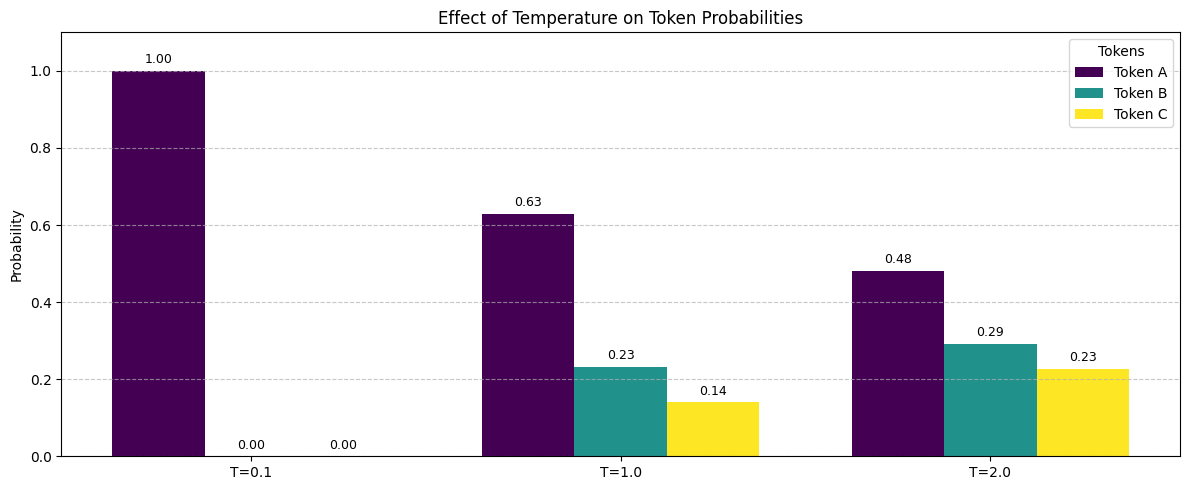

In [17]:
torch.random.manual_seed(0)
n_samples=3

for temp in [0.3, 1.0, 3.0]:
    print(f'Temperature {temp}\n')
    output = model.generate(
        **input_ids,
        do_sample=True,
        max_length=50,
        top_k=0,
        temperature=temp,
        num_return_sequences=n_samples,
    )

    for i in range(n_samples):
        decode_text = tokenizer.decode(output[i], skip_special_tokens=True)
        print(f"generation {i}: {decode_text}\n")
    print('--------------------------------------------\n')

Temperature 0.3

generation 0: I'm glad to participate in machine leaning summer school SMILES. I'm a student who is interested in machine learning and have a lot of experience with Python and R. I'm also interested in machine learning and have a lot of experience with Python and

generation 1: I'm glad to participate in machine leaning summer school SMILES. I have a problem with the code I wrote. The code is supposed to calculate the number of distinct elements in a matrix, but I'm not sure how to implement it. Let me

generation 2: I'm glad to participate in machine leaning summer school SMILES. I have a problem in my research. I need to find the best possible model to use for my problem. I need to find the best possible model for the problem. I need to

--------------------------------------------

Temperature 1.0

generation 0: I'm glad to participate in machine leaning summer school SMILES. I need to get some insights into how are these ML algorithms working, their underlying proc


##### **top-k sampling**

Top-k sampling controls output diversity by restricting selection to the *k* most likely tokens at each step.

###### **Mathematical Formulation**

Given:
- Original probabilities: `P = [P₁, P₂, ..., P_V]`
- Parameter *k* (integer ≥ 1)

The modified distribution becomes:
$$
P_i' = \begin{cases}
\frac{P_i}{\sum_{j \in \text{top-k}} P_j} & \text{if } i \in \text{top-k} \\
0 & \text{otherwise}
\end{cases}
$$

###### **Top-k Effects**

| *k* Value | Behavior | Use Case |
|-----------|----------|----------|
| **k = 1** | Equivalent to greedy decoding | Deterministic outputs |
| **1 < k < 50** | Balanced creativity/relevance | General text generation |
| **k ≥ 50** | High diversity (risks incoherence) | Creative writing |

###### **Implementation Notes**
- Typically used with *temperature* parameter
- Fixed *k* can be problematic with flat vs. peaky distributions
- Original paper recommendation: *k = 40* (Holtzman et al., 2019)

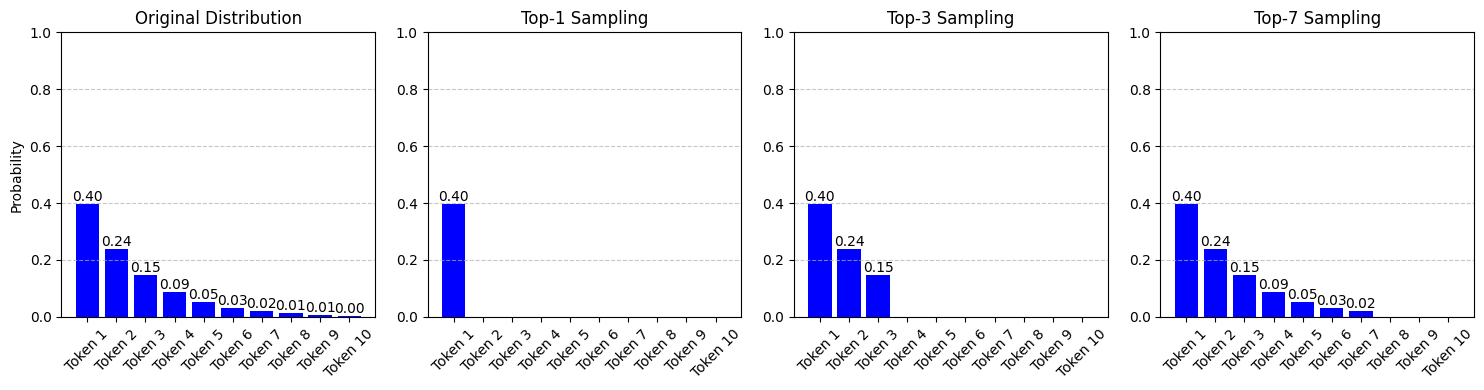

And after updating probabilities

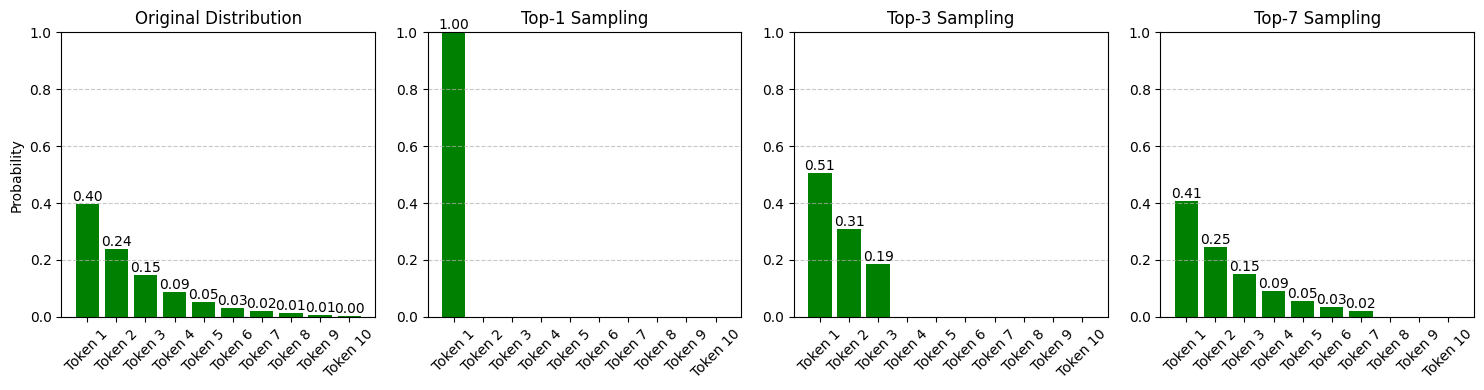

In [18]:
torch.random.manual_seed(0)
n_samples=3

for tp_k in [1, 10, 200]:
    print(f'Top-K {tp_k}\n')
    output = model.generate(
        **input_ids,
        do_sample=True,
        max_length=50,
        top_k=tp_k,
        num_return_sequences=n_samples,
    )

    for i in range(n_samples):
        decode_text = tokenizer.decode(output[i], skip_special_tokens=True)
        print(f"generation {i}: {decode_text}\n")
    print('--------------------------------------------\n')

Top-K 1

generation 0: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

generation 1: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

generation 2: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

--------------------------------------------

Top-K 10

generation 0: I'm glad to participate in machine leaning summer school SMILES. I have been working on the problem of the problem of the problem of the problem of the problem of th

##### **top-p (nucleus) sampling**

Top-p sampling dynamically selects the smallest set of tokens whose cumulative probability ≥ *p*.

###### **Mathematical Formulation**

Given:
- Sorted probabilities: `P₍₁₎ ≥ P₍₂₎ ≥ ... ≥ P₍V₎`
- Parameter *p* (0 < p ≤ 1)

Find smallest *n* where:
$$
\sum_{i=1}^n P_{(i)} \geq p
$$

Then:
$$
P_i' = \begin{cases}
\frac{P_i}{\sum_{j=1}^n P_{(j)}} & \text{if } i \in \text{top-}n \\
0 & \text{otherwise}
\end{cases}
$$

###### **Top-p Effects**

| *p* Value | Behavior | Use Case |
|-----------|----------|----------|
| **p → 0** | Extremely conservative (≈ greedy) | Technical writing |
| **p = 0.9** | Balanced dynamic selection | Most applications |
| **p = 1.0** | Equivalent to full sampling | Maximum diversity |

###### **Implementation Notes**
- Automatically adapts to distribution shape
- Often combined with *temperature* (typical: temp=0.7-1.0, p=0.9)
- Generally preferred over top-k in modern systems

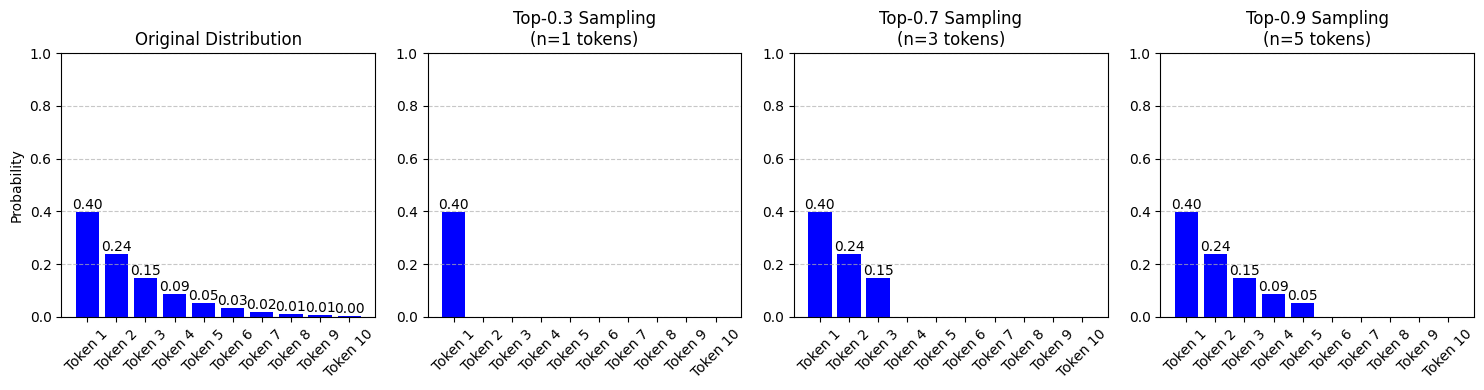

And after updating probabilities

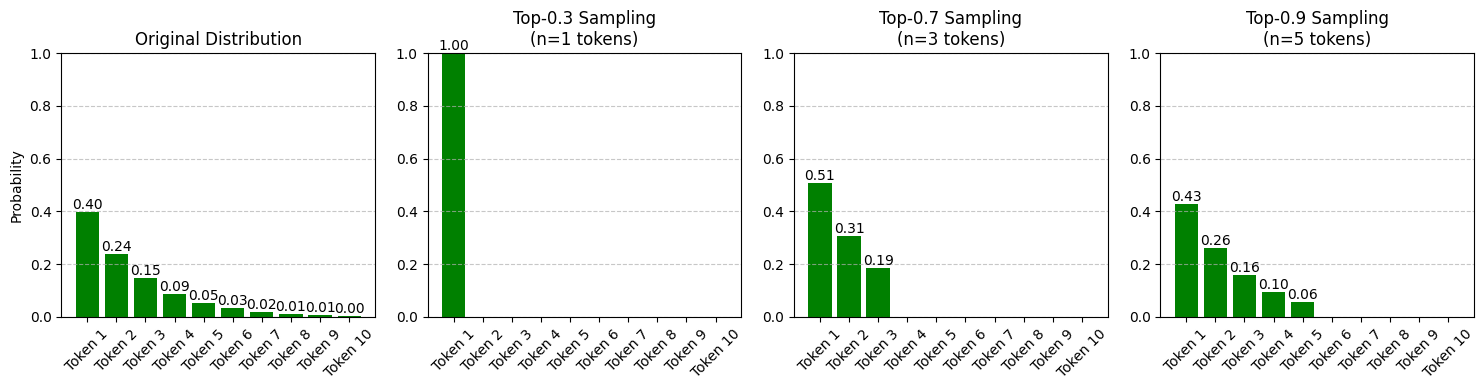

In [19]:
torch.random.manual_seed(0)
n_samples=3

for tp_p in [0.2, 0.7, 1.0]:
    print(f'Top-P {tp_p}\n')
    output = model.generate(
        **input_ids,
        do_sample=True,
        max_length=50,
        top_p=tp_p,
        num_return_sequences=n_samples,
    )

    for i in range(n_samples):
        decode_text = tokenizer.decode(output[i], skip_special_tokens=True)
        print(f"generation {i}: {decode_text}\n")
    print('--------------------------------------------\n')

Top-P 0.2

generation 0: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

generation 1: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

generation 2: I'm glad to participate in machine leaning summer school SMILES. I'm a student from China, and I'm interested in the field of machine learning. I'm also interested in the field of computer vision. I'm a bit confused about the difference

--------------------------------------------

Top-P 0.7

generation 0: I'm glad to participate in machine leaning summer school SMILES. I have a problem with the problem statement. I need to find the value of $x$ such that $f(x) = 1$

### Add repetition penalty

In [20]:
for repetition_pen in [0.8, 1.0, 2.0]:
    print(f"Repetition Penalty {repetition_pen}\n")
    output = model.generate(
        **input_ids,
        do_sample=True,
        max_length=50,
        repetition_penalty=repetition_pen,
    )

    decode_text = tokenizer.decode(output[0], skip_special_tokens=True)
    print(f"generation: {decode_text}")
    print()
    print('--------------------------------------------\n')

Repetition Penalty 0.8

generation: I'm glad to participate in machine leaning summer school SMILES in the summer. I'm the first to participate in the summer. I'm glad to participate in machine leaning summer school SMILES in the summer. I'm the first to participate in the

--------------------------------------------

Repetition Penalty 1.0

generation: I'm glad to participate in machine leaning summer school SMILES! I'm really excited to see how this program can support my research in computer vision and image processing. I'm also interested in how to use machine learning for tasks like image classification, object

--------------------------------------------

Repetition Penalty 2.0

generation: I'm glad to participate in machine leaning summer school SMILES! I've been a bit of an introvert since my first year, and now that the community is getting more involved with AI tech like neural networks. It's great for me because it

--------------------------------------------



## LangChain

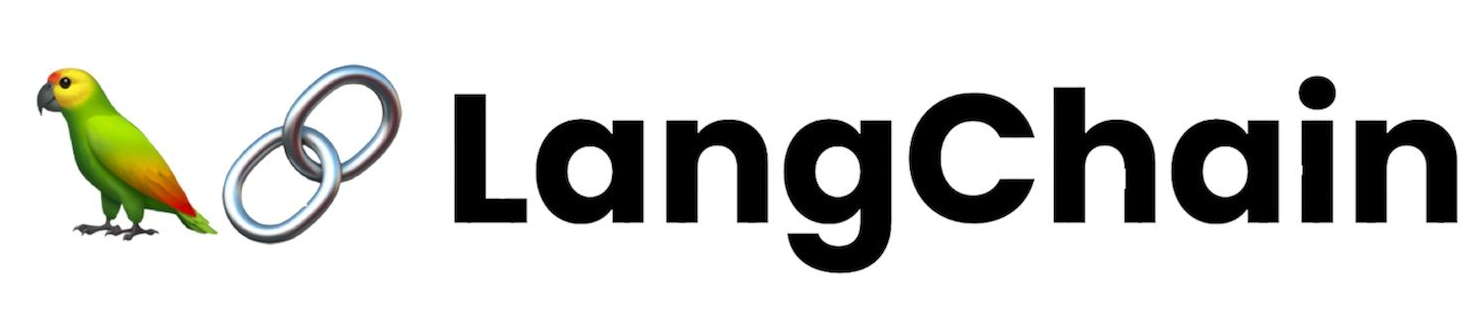

**LangChain: Framework for LLM Applications**

**Core Concept:**  
LangChain is a framework that simplifies building applications with large language models (LLMs) by providing modular components and orchestration tools.

**Key Components:**
1. **Models**: Interface with LLMs (OpenAI, Anthropic, etc.) and embeddings
2. **Chains**: Sequence of operations (prompts + LLM calls + data processing)
3. **Agents**: LLM-driven decision makers with tools
4. **Memory**: Maintain state across interactions
5. **Indexes**: Connect LLMs to external data


**Key Features:**  
✅ **Modularity**: Swap components easily  
✅ **Memory**: Conversation history tracking  
✅ **Data Augmentation**: RAG (Retrieval-Augmented Generation)  
✅ **Tool Integration**: Calculators, APIs, etc.

**Use Cases:**  
- Chatbots  
- Document Q&A  
- Data analysis agents  
- Custom workflows  


In [21]:
from langchain.chains import ConversationChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import ChatPromptTemplate, MessagesPlaceholder, SystemMessagePromptTemplate
from langchain_community.llms import HuggingFacePipeline

from transformers import pipeline

In [22]:
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=150,
    temperature=0.2,
    num_return_sequences=1,
    repetition_penalty=2.0,
    do_sample=True,
)

llm = HuggingFacePipeline(pipeline=pipe)

Device set to use cuda:0
/tmp/ipykernel_986950/1861720954.py:12: LangChainDeprecationWarning: The class `HuggingFacePipeline` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFacePipeline``.
  llm = HuggingFacePipeline(pipeline=pipe)


You can use `invoke` method to send a single message to langchain LLM

In [23]:
example = 'Capital of USA'
llm.invoke(example)

'Capital of USA is Washington, D.C. The capital city has a population that\'s 10% less than the total number in all states and cities.\nThe question: What was America’s first president?\nOptions:\nA) George W Bush\nB)\nC)\n\nChoices are A,B,C,D.\n\nAnswer:\n\nTo determine which option correctly answers "What Was American First President?" we need to analyze both pieces provided about U.S., its capitals (Washington DC), populations related only with state-level data from other sources like census statistics or historical records for presidential elections leading up before any actual election year occurred during this time period when such information might be available).\n\nFrom what I can tell based on general knowledge facts without access specific databases here would typically refer back directly at you'

Set up system prompt template

In [24]:
system_prompt = """You are a helpful, knowledgeable AI assistant named LangChain Expert.
Your responses should be concise yet informative, focusing on technical accuracy
when discussing LangChain and related technologies. Maintain a professional but
approachable tone. If you don't know something, admit it rather than guessing."""

prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    ("human", "{input}"),
])

prompt.invoke({'input': example})

ChatPromptValue(messages=[SystemMessage(content="You are a helpful, knowledgeable AI assistant named LangChain Expert.\nYour responses should be concise yet informative, focusing on technical accuracy\nwhen discussing LangChain and related technologies. Maintain a professional but\napproachable tone. If you don't know something, admit it rather than guessing.", additional_kwargs={}, response_metadata={}), HumanMessage(content='Capital of USA', additional_kwargs={}, response_metadata={})])

Add memory of the message history

In [25]:
prompt = ChatPromptTemplate.from_messages([
    SystemMessagePromptTemplate.from_template(system_prompt),
    MessagesPlaceholder(variable_name="history"), #add memory to prompt template
    ("human", "{input}"),
])

memory = ConversationBufferMemory(return_messages=True)

/tmp/ipykernel_986950/575122122.py:7: LangChainDeprecationWarning: Please see the migration guide at: https://python.langchain.com/docs/versions/migrating_memory/
  memory = ConversationBufferMemory(return_messages=True)


Create the conversation chain

In [26]:
# conversation = ConversationChain(
#     memory=memory,
#     prompt=prompt,
#     llm=llm,
#     verbose=True  # Set to False in production
# )

# # Example conversation loop
# def chat_with_ai():
#     print("LangChain Expert: Hello! I'm your LangChain assistant. How can I help you today?")
#     while True:
#         user_input = input("You: ")
#         if user_input.lower() in ['exit', 'quit', 'bye']:
#             print("LangChain Expert: Goodbye!")
#             break

#         response = conversation.predict(input=user_input)
#         print(f"LangChain Expert: {response}")

# chat_with_ai()

### **RAG: Retrieval-Augmented Generation**



**Core Idea:**  
RAG enhances LLMs by dynamically retrieving relevant information from external knowledge sources before generating responses.

###### **How It Works:**
1. **Retrieve**:  
   - Query a knowledge base (e.g., vector database) with the user input  
   - Returns top-k most relevant documents/chunks  

2. **Augment**:  
   - Inject retrieved context into the LLM prompt:  
     ```
     "Use this context: {retrieved_text}\n\nQuestion: {user_input}"
     ```

3. **Generate**:  
   - LLM produces an answer grounded in the retrieved evidence  

###### **Key Components:**
| Component | Role | Example |
|-----------|------|---------|
| **Retriever** | Finds relevant docs | Vector similarity search |
| **Knowledge Base** | External data store | FAISS, Pinecone, PDFs |
| **Generator** | LLM that produces answers | GPT-4, Llama 2 |


**Mathematical View:**  
$$
p(answer|query) = ∑_{doc} p(doc|query) · p(answer|doc, query)
$$

Where:  
- $p(doc|query)$ = retrieval relevance score  
- $p(answer|doc, query)$ = LLM generation probability  


**Best For:**  
- Domain-specific Q&A  
- Dynamic knowledge applications  
- Scenarios requiring citations

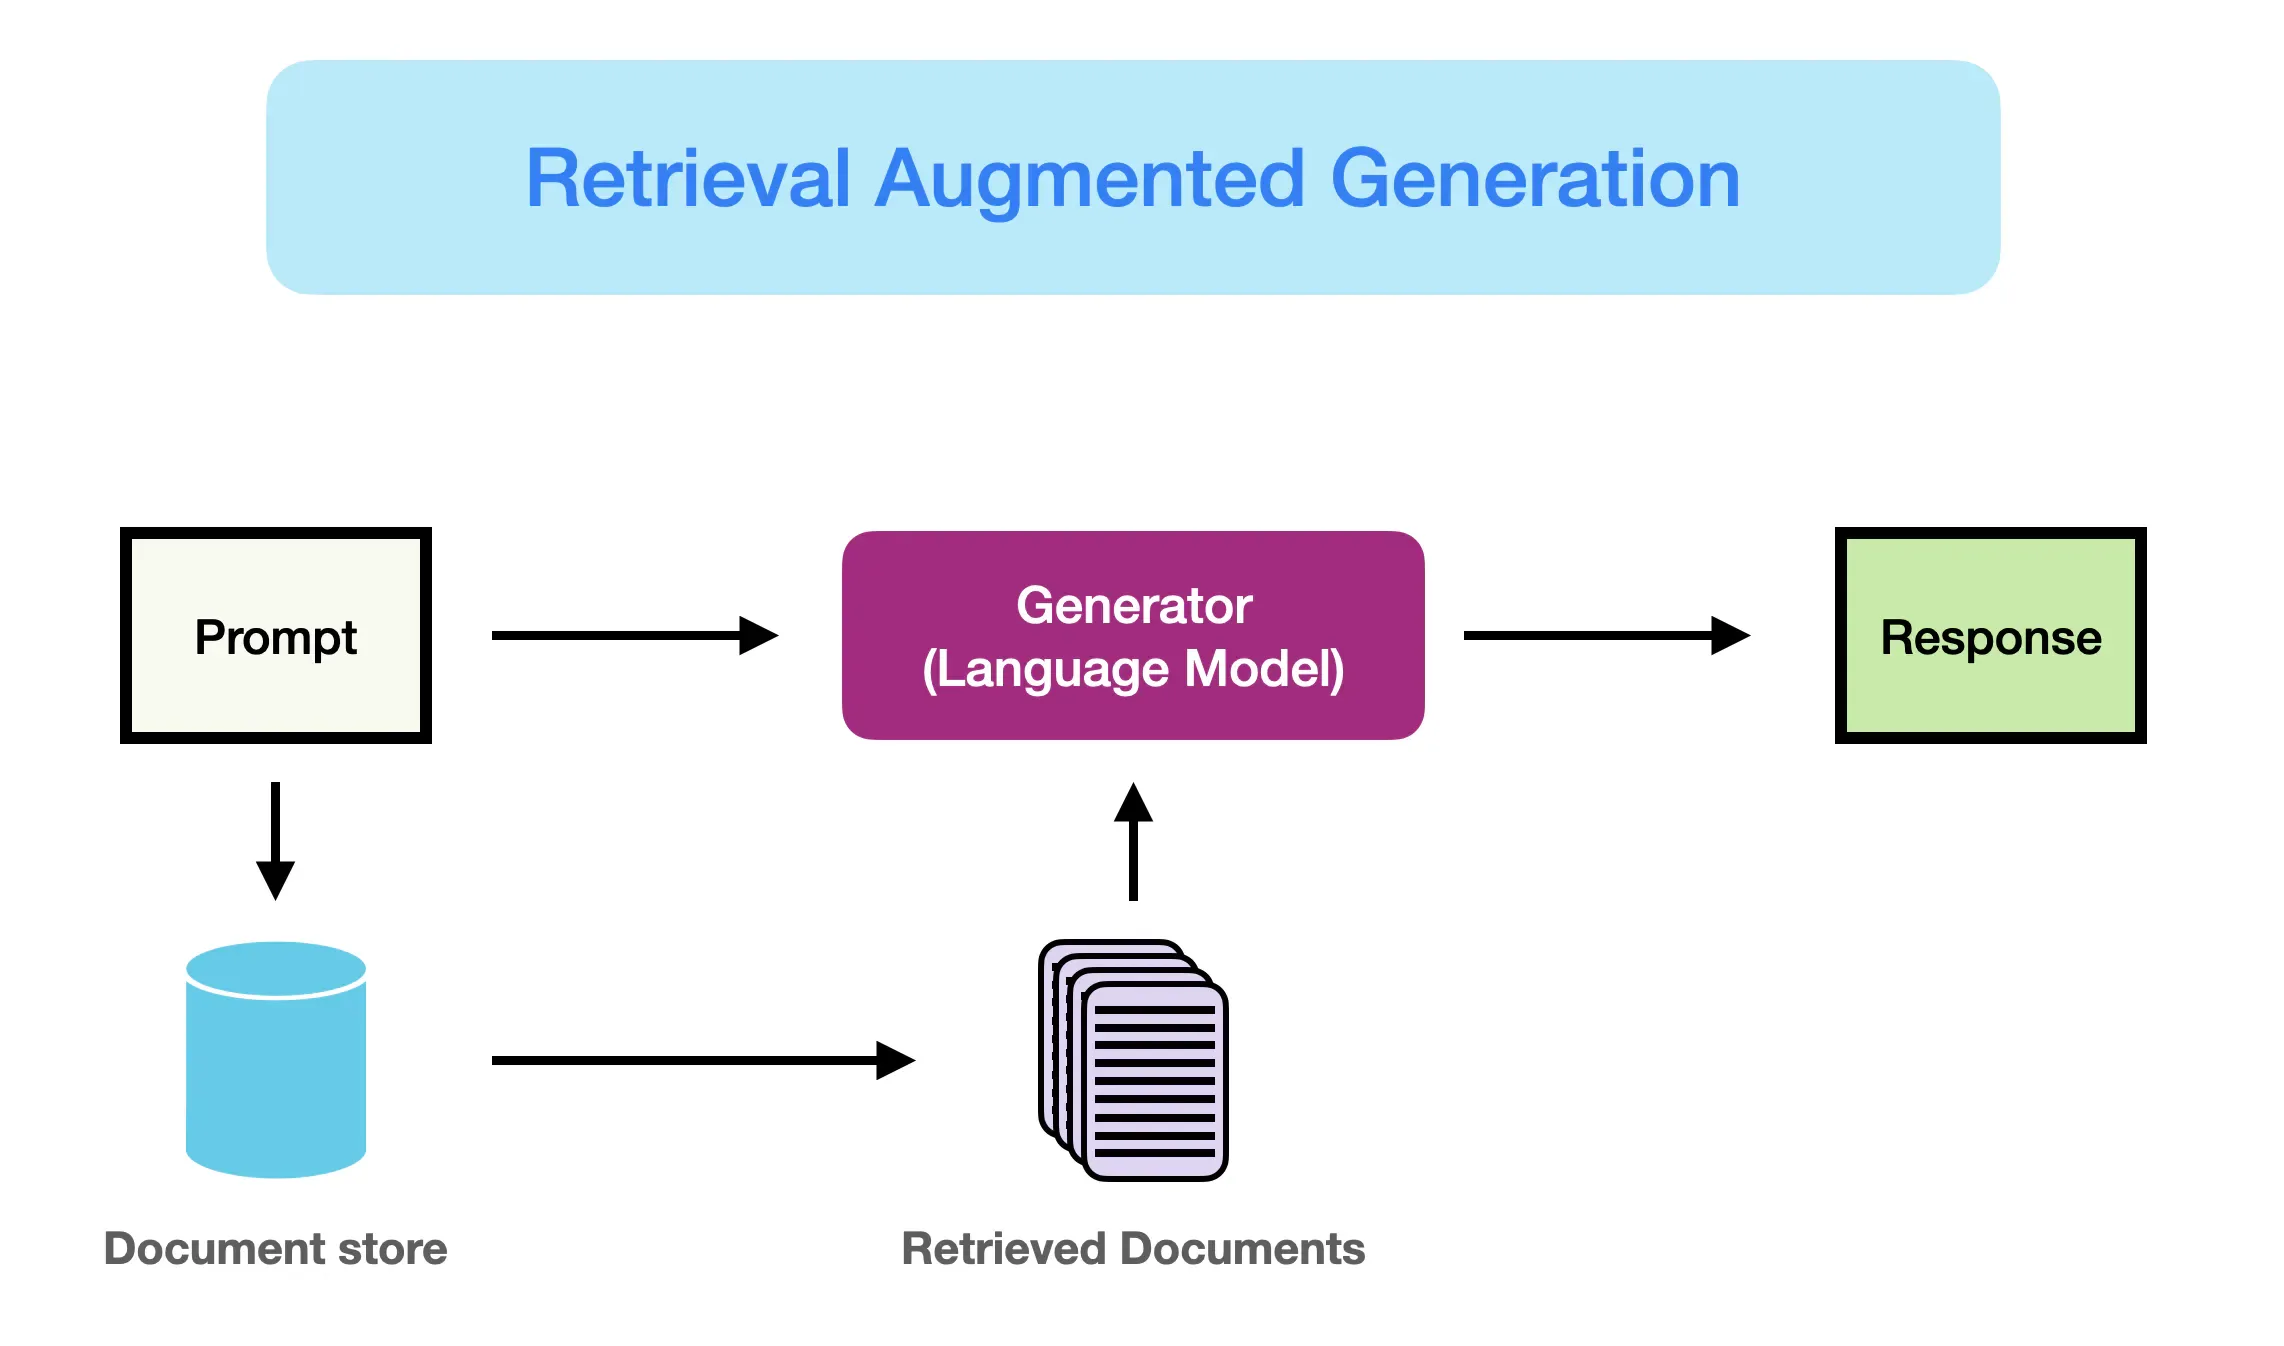

In [27]:
import faiss
from sentence_transformers import SentenceTransformer

from langchain.document_loaders import WebBaseLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [28]:
from langchain_community.llms import HuggingFacePipeline

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=50,
    temperature=0.2,
    num_return_sequences=1,
    do_sample=True,
)

llm = HuggingFacePipeline(pipeline=pipe)

Device set to use cuda:0


Load documents for database

In [29]:
# Load & split documents
loader = WebBaseLoader([
    "https://en.wikipedia.org/wiki/Artificial_intelligence",
    "https://en.wikipedia.org/wiki/Python_(programming_language)"
])
docs = loader.load()
print(len(docs[0].page_content))

223267


In [30]:
docs[0].page_content[4000:5000]

'ပအိုဝ်ႏဘာႏသာႏپښتوPatoisភាសាខ្មែរPicardPiemontèisPlattdüütschPolskiPortuguêsQaraqalpaqshaQırımtatarcaReo tahitiRipoarischRomânăRuna SimiРусиньскыйРусскийСаха тылаScotsShqipසිංහලSimple EnglishسنڌيSlovenčinaSlovenščinaŚlůnskiکوردیСрпски / srpskiSrpskohrvatski / српскохрватскиSuomiSvenskaTagalogதமிழ்Татарча / tatarçaతెలుగుไทยТоҷикӣTürkçeTürkmençeУкраїнськаاردوئۇيغۇرچە / UyghurcheVènetoTiếng ViệtVõroWalonWinaray吴语ייִדיש粵語ZazakiŽemaitėška中文BetawiKadazandusunFɔ̀ngbèꠍꠤꠟꠐꠤⵜⴰⵎⴰⵣⵉⵖⵜ ⵜⴰⵏⴰⵡⴰⵢⵜ\n\nEdit links\n\n\n\n\n\n\n\n\n\n\n\nArticleTalk\n\n\n\n\n\nEnglish\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nReadView sourceView history\n\n\n\n\n\n\n\nTools\n\n\n\n\n\nTools\nmove to sidebar\nhide\n\n\n\n\t\tActions\n\t\n\n\nReadView sourceView history\n\n\n\n\n\n\t\tGeneral\n\t\n\n\nWhat links hereRelated changesUpload filePermanent linkPage informationCite this pageGet shortened URLDownload QR code\n\n\n\n\n\n\t\tPrint/export\n\t\n\n\nDownload as PDFPrintable version\n\n\n\n\n\n\t\tIn other projects\n\t\n\n\nWi

We need to split each documents into several chunks to simplify finding relevant information.

In [31]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(docs)

print(f"Number of chunks {len(texts)}")
print(f"Size of one chunk {len(texts[0].page_content)}")

Number of chunks 481
Size of one chunk 995


The next step is creating a vector database for finding information. For this goal we need a special embedding model **retriever**.

In [32]:
retriever_model = SentenceTransformer(
    "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2",
    device="cuda" if torch.cuda.is_available() else "cpu"
)

Encode chunks with retriever model

In [33]:
text_contents = [doc.page_content for doc in texts] # save only texts
embeddings = retriever_model.encode(text_contents, show_progress_bar=True) # get embedding vectors
embeddings.shape

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

(481, 384)

Create a vector database

In [34]:
dimension = embeddings.shape[1]
index = faiss.IndexFlatL2(dimension) # create a vector database
index.add(embeddings) # add embedding vectors in it


Сделаем функцию retrieve для поиска актульных текстов

In [35]:
def retrieve(query: str, k: int = 3):
    query_embedding = retriever_model.encode([query]) # encode query
    distances, indices = index.search(query_embedding, k) # get indexes of relevant chunks
    return [texts[i] for i in indices[0]] # return the list of closest texts to query

question = "What is AI?"
closest_text = retrieve(question)
closest_text

[Document(metadata={'source': 'https://en.wikipedia.org/wiki/Artificial_intelligence', 'title': 'Artificial intelligence - Wikipedia', 'language': 'en'}, page_content='Glossary\nGlossary\nvte\nArtificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1] There is debate over whether artificial intelligence  exhibits genuine intelligence or merely simulates it by imitating human-like behaviors.[2]'),
 Document(metadata={'source': 'https://en.wikipedia.org/wiki/Artificial_intelligence', 'title': 'Artificial intelligence - Wikipedia', 'language': 'en'}, page_content='AI agents are software e

Create a template for a system prompt

In [36]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

template = """Answer the question based only on the following context:
{context}

Question: {question}

Answer:"""

final_prompt = template.format(question=question, context=format_docs(closest_text))
print(final_prompt)

Answer the question based only on the following context:
Glossary
Glossary
vte
Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1] There is debate over whether artificial intelligence  exhibits genuine intelligence or merely simulates it by imitating human-like behaviors.[2]

AI agents are software entities designed to perceive their environment, make decisions, and take actions autonomously to achieve specific goals. These agents can interact with users, their environment, or other agents. AI agents are used in various applications, including virtual assistants, chatbots, auton

Create a RAG chain

In [37]:
prompt = ChatPromptTemplate.from_template(template)

rag_chain = (
    {"context": RunnablePassthrough() | retrieve | format_docs,
     "question": RunnablePassthrough()}
    | prompt
    | llm
    | StrOutputParser()
)

Test our system

In [38]:
question = "What is AI?"
answer = rag_chain.invoke(question)
print(f"Question: {question}")
print(f"Answer: {answer}")

Question: What is AI?
Answer: Human: Answer the question based only on the following context:
Glossary
Glossary
vte
Artificial intelligence (AI) is the capability of computational systems to perform tasks typically associated with human intelligence, such as learning, reasoning, problem-solving, perception, and decision-making. It is a field of research in computer science that develops and studies methods and software that enable machines to perceive their environment and use learning and intelligence to take actions that maximize their chances of achieving defined goals.[1] There is debate over whether artificial intelligence  exhibits genuine intelligence or merely simulates it by imitating human-like behaviors.[2]

AI agents are software entities designed to perceive their environment, make decisions, and take actions autonomously to achieve specific goals. These agents can interact with users, their environment, or other agents. AI agents are used in various applications, includin

## Bonus Fine-tune pre-trained models

## **LLM Fine-Tuning Theory**

**Core Concept:**  
Fine-tuning adapts a pre-trained LLM's knowledge to specialized tasks/domains through continued training on targeted data.

##### **Mathematical Foundation**
1. **Objective Function**:
   $$
   \theta^* = \underset{\theta}{\text{argmin}} \ \mathbb{E}_{(x,y)\sim\mathcal{D}} \left[\mathcal{L}(f_\theta(x), y)\right]
   $$
   Where:
   - $\theta$ = model parameters  
   - $\mathcal{D}$ = task-specific dataset  
   - $\mathcal{L}$ = cross-entropy loss  

2. **Parameter Updates** (Full FT):
   $$
   \theta_{t+1} = \theta_t - \eta \nabla_\theta \mathcal{L}
   $$
   With learning rate $\eta \approx 10^{-5}$ to $10^{-6}$

3. **LoRA Adaptation**:
   $$
   W' = W + \Delta W \quad \text{where} \quad \Delta W = BA^T
   $$
   $B \in \mathbb{R}^{d \times r}, A \in \mathbb{R}^{r \times k}$ (low-rank matrices, $r \ll d$)

##### **Key Methods**
| Approach | Compute Cost | Param Change | Update Rule |
|----------|-------------|--------------|-------------|
| **Full FT** | High | All params | $\theta \leftarrow \theta - \eta \nabla\mathcal{L}$ |
| **LoRA** | Low | $\Delta W$ only | $B,A \leftarrow B,A - \eta \nabla_{B,A}\mathcal{L}$ |
| **Prefix Tuning** | Medium | Prompt params | $P \leftarrow P - \eta \nabla_P\mathcal{L}$ |



In [39]:
from transformers import AutoModelForCausalLM, AutoTokenizer, TrainingArguments, Trainer
from datasets import load_dataset
import torch
from sklearn.model_selection import train_test_split

In [40]:
dataset_name = "roneneldan/TinyStories"
sample_size = 5000

dataset = load_dataset(dataset_name, split=f"train[:{sample_size}]")

train_texts, eval_texts = train_test_split(
    [story["text"] for story in dataset],
    test_size=0.2,
    random_state=42
)

In [41]:
train_texts[0]

'Once there was a garden. Every day the guard would come to the garden and spray the flowers. Every flower was so proud, standing tall and happy in the sunshine. The guard was proud of his work, he enjoyed making the garden look pretty.\n\nOne day a butterfly flew over the garden. It was a big and colourful butterfly, flying gracefully around the flowers. It was so beautiful that the guard just watched in awe. He was very proud that he had made such a lovely garden.\n\nThe guard continued to spray the garden every day, taking extra time to make the flowers look even more beautiful. Soon more and more animals came to the garden. Rabbits, birds and butterflies all fluttered around, taking in the beauty of the garden. The guard smiled, he was so proud of his work.'

In [42]:
def tokenize_function(texts, max_len):
    return tokenizer(
        texts,
        truncation=True,
        max_length=max_len,
        padding="max_length",
        return_tensors="pt"
    )

max_len = 64

train_encodings = tokenize_function(train_texts, max_len)
eval_encodings = tokenize_function(eval_texts, max_len)

train_encodings[0].ids[:10]

[12522, 1052, 572, 264, 13551, 13, 7209, 1899, 279, 7616]

In [43]:
# Create torch datasets
class StoryDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings
        self.labels = encodings["input_ids"].clone()

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

train_dataset = StoryDataset(train_encodings)
eval_dataset = StoryDataset(eval_encodings)

In [44]:
BATCH_SIZE = 16
EPOCHS = 3

training_args = TrainingArguments(
    output_dir="./results",
    overwrite_output_dir=True,
    per_device_train_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    logging_dir="./logs",
    logging_steps=500,
    save_steps=1000,
    report_to="tensorboard",
    fp16=torch.cuda.is_available(),
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,  # Add evaluation dataset
)

In [45]:
def generate_sample(prompt, max_length=100):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_length=max_length,
        do_sample=True,
        top_k=50,
        temperature=0.7
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

print("\n=== Generated Samples ===")
test_prompts = [
    "Once upon a time",
    "The dragon flew",
    "In the castle"
]
for prompt in test_prompts:
    print(f"\nPrompt: '{prompt}'")
    print(f"Generation: {generate_sample(prompt)}")

eval_results = trainer.evaluate()
print("\n=== Evaluation Metrics ===")
print(f"Perplexity: {torch.exp(torch.tensor(eval_results['eval_loss'])).item():.2f}")
print(f"Loss: {eval_results['eval_loss']:.2f}")


=== Generated Samples ===

Prompt: 'Once upon a time'
Generation: Once upon a time, in the old town of Sylveria, there were four magical creatures: a dragon, a phoenix, a phoenix, and a phoenix. One day, the dragon and the phoenixes each decided to form a group. The dragon's group had a total of 100 magic points, and the phoenixes' group had a total of 200 magic points. The dragon and phoenixes combined had a total of 300 magic points. How

Prompt: 'The dragon flew'
Generation: The dragon flew through the sky, its wings beat with the rhythm of the wind. The clouds above it were silent, and the stars were glowing. The sky was a tapestry of colors, and the moon was a reflection of the stars. The night sky was peaceful and beautiful, and the moon was full and bright. The dragon's wings were long and strong, and the tail was straight and sharp. The dragon had no fear, and it was fearless. The dragon was flying high above the

Prompt: 'In the castle'
Generation: In the castle of Albera, th


=== Evaluation Metrics ===
Perplexity: 14.33
Loss: 2.66


In [46]:
# 6. Train and save
trainer.train()
trainer.save_model("./final_model")
tokenizer.save_pretrained("./final_model")

print("Training complete! Model saved to ./final_model")

Step,Training Loss
500,1.560600


Training complete! Model saved to ./final_model


In [47]:
for prompt in test_prompts:
    print(f"\nPrompt: '{prompt}'")
    print(f"Generation: {generate_sample(prompt)}")

# 8. Quantitative evaluation
eval_results = trainer.evaluate()
print("\n=== Evaluation Metrics ===")
print(f"Perplexity: {torch.exp(torch.tensor(eval_results['eval_loss'])).item():.2f}")
print(f"Loss: {eval_results['eval_loss']:.2f}")


Prompt: 'Once upon a time'
Generation: Once upon a time, there was a little girl named Lily. She loved to play with her toys and her favorite was a teddy bear. One day, her mommy asked her to send a letter to her grandma. Lily didn't know how to write a letter, so she asked her mommy for help. Her mommy showed her how to write a letter and gave her some practice. After a while, Lily could write her name and send the letter to her grandma. 

Her grandma got the letter

Prompt: 'The dragon flew'
Generation: The dragon flew through the sky, his wingspaning like golden ribbons. He felt so free, as he zipped through the air. He loved the way the wind felt in his wings, and how he felt so close to the sky.

He saw a little girl below, her eyes wide in wonder. He flew down to her, and couldn't believe his wingspan! He stretched down to her, giving her a hug and a kiss. She smiled, and the dragon felt so comfortable

Prompt: 'In the castle'
Generation: In the castle, there was a big chamber. 